In [1]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
def download_stock_data(symbols, start, end):
    """
    Download historical stock data for multiple symbols using yfinance.
    
    Parameters:
    - symbols (list): List of stock symbols to download.
    - start (str): Start date in 'YYYY-MM-DD' format.
    - end (str): End date in 'YYYY-MM-DD' format.
    
    Returns:
    - pd.DataFrame: DataFrame containing adjusted close prices for the symbols.
    """
    data = yf.download(symbols, start=start, end=end)['Adj Close']
    return data

def fetch_stock_metrics(tickers):
    """
    Fetch P/E ratios, earnings growth rates, and PEG ratios for a list of stocks.
    
    Parameters:
    - tickers (list): List of stock tickers to analyze.
    
    Returns:
    - pd.DataFrame: DataFrame containing metrics for each stock.
    """
    metrics = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            pe_ratio = info.get('trailingPE', None)
            growth_rate = info.get('earningsQuarterlyGrowth', None)  # Quarterly growth rate
            peg_ratio = info.get('pegRatio', None)
            metrics.append({
                "Ticker": ticker,
                "P/E Ratio": pe_ratio,
                "Growth Rate": growth_rate,
                "PEG Ratio": peg_ratio
            })
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            metrics.append({
                "Ticker": ticker,
                "P/E Ratio": None,
                "Growth Rate": None,
                "PEG Ratio": None
            })
    return pd.DataFrame(metrics)

ALPHA_VANTAGE_API_KEY = "UVT073E3KZPAMB6B"  # Replace with your API key

def fetch_alpha_vantage_metrics(tickers):
    """
    Fetch financial metrics (P/E ratio, growth rate, PEG ratio) using Alpha Vantage.
    
    Parameters:
    - tickers (list): List of stock tickers to analyze.
    
    Returns:
    - pd.DataFrame: DataFrame containing metrics for each stock.
    """
    metrics = []
    base_url = "https://www.alphavantage.co/query"
    
    for ticker in tickers:
        try:
            # Fetch earnings data (e.g., P/E ratio, growth rate)
            response = requests.get(base_url, params={
                "function": "OVERVIEW",
                "symbol": ticker,
                "apikey": ALPHA_VANTAGE_API_KEY
            })
            data = response.json()
            
            # Extract metrics
            pe_ratio = float(data.get('PERatio', 'NaN'))
            peg_ratio = float(data.get('PEGRatio', 'NaN'))
            growth_rate = float(data.get('QuarterlyEarningsGrowthYOY', 'NaN'))  # Example field
            
            metrics.append({
                "Ticker": ticker,
                "P/E Ratio": pe_ratio,
                "Growth Rate": growth_rate,
                "PEG Ratio": peg_ratio
            })
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            metrics.append({
                "Ticker": ticker,
                "P/E Ratio": None,
                "Growth Rate": None,
                "PEG Ratio": None
            })
    return pd.DataFrame(metrics)

def normalize_prices(stock_data):
    """
    Normalize stock prices to a common starting value (e.g., 100).
    
    Parameters:
    - stock_data (pd.DataFrame): DataFrame of adjusted close prices.
    
    Returns:
    - pd.DataFrame: Normalized stock prices.
    """
    return stock_data / stock_data.iloc[0] * 100

def plot_index_comparison(stock_data, title="Stock Index Comparison"):
    """
    Plot normalized stock prices for comparison.
    
    Parameters:
    - stock_data (pd.DataFrame): DataFrame of normalized stock prices.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 8))
    
    for column in stock_data.columns:
        plt.plot(stock_data.index, stock_data[column], label=column)
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Index (Starting at 100)")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compare_stocks_by_index(tickers, start_date, end_date):
    """
    Compare the performance of a list of stocks by indexing their prices.
    
    Parameters:
    - tickers (list): List of stock tickers to compare.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.
    """
    # Fetch stock data
    stock_data = download_stock_data(tickers, start_date, end_date)
    if stock_data.empty:
        print(f"NO DATA: {stock_data}")
    else:
        # Normalize prices
        normalized_data = normalize_prices(stock_data)

        # Plot comparison
        plot_index_comparison(normalized_data, title="Indexed Performance of Stocks")

In [3]:
# compare P/E ratio info
def get_pe_ratios(tickers):
    """
    Fetch the P/E ratios for a list of stock tickers.
    
    Parameters:
    - tickers (list): List of stock tickers to fetch.
    
    Returns:
    - pd.DataFrame: DataFrame containing stock tickers and their P/E ratios.
    """
    pe_ratios = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            pe_ratio = stock.info.get('trailingPE', None)
            pe_ratios.append({"Ticker": ticker, "P/E Ratio": pe_ratio})
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            pe_ratios.append({"Ticker": ticker, "P/E Ratio": None})
    return pd.DataFrame(pe_ratios)

def plot_pe_ratios(pe_data):
    """
    Create a mosaic plot of P/E ratios for a list of stocks.
    
    Parameters:
    - pe_data (pd.DataFrame): DataFrame containing stock tickers and their P/E ratios.
    """
    # Filter out stocks with missing P/E ratios
    pe_data = pe_data.dropna(subset=["P/E Ratio"])
    
    # Sort data by P/E Ratio
    pe_data = pe_data.sort_values(by="P/E Ratio", ascending=True)
    
    # Create mosaic bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(pe_data["Ticker"], pe_data["P/E Ratio"], color='skyblue')
    plt.title("P/E Ratio Comparison of Stocks")
    plt.xlabel("P/E Ratio")
    plt.ylabel("Stock Ticker")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_pe_ratios_colormesh(pe_data):
    """
    Create a color mesh graph of P/E ratios for a list of stocks.
    
    Parameters:
    - pe_data (pd.DataFrame): DataFrame containing stock tickers and their P/E ratios.
    """
    # Filter out stocks with missing P/E ratios
    pe_data = pe_data.dropna(subset=["P/E Ratio"])
    
    # Sort data by P/E Ratio
    pe_data = pe_data.sort_values(by="P/E Ratio", ascending=True)
    
    # Prepare data for the color mesh
    x = np.arange(len(pe_data))  # Ticker indices
    y = np.array([0, 1])  # Single row for P/E ratios
    z = np.array([pe_data["P/E Ratio"].values])  # P/E ratios
    print([x, y, z])
    #print(f"x: {x.shape}, y: {y.shape}, z: {z.shape}")
    
    # Ensure z matches the shape defined by x and y
    #if z.shape[1] != len(x) - 1 or z.shape[0] != len(y) - 1:
    #    raise ValueError("Mismatch between z dimensions and x, y grid boundaries.")
    
    # Create the color mesh plot
    fig, ax = plt.subplots(figsize=(12, 4))
    mesh = ax.pcolormesh(x, y, z, shading='nearest', cmap='viridis')
    plt.colorbar(mesh, label="P/E Ratio")
    
    # Set axis labels and ticks
    ax.set_xticks(np.arange(len(pe_data)) + 0.5)
    ax.set_xticklabels(pe_data["Ticker"], rotation=45)
    ax.set_yticks([])
    ax.set_title("P/E Ratio Comparison (Color Mesh)")
    ax.set_xlabel("Stock Tickers")
    
    plt.tight_layout()
    plt.show()
    
def compare_pe_ratios(tickers, graphc = 1):
    """
    Compare P/E ratios of a list of stocks and visualize them in a mosaic plot.
    
    Parameters:
    - tickers (list): List of stock tickers to compare.
    """
    # Fetch P/E ratios
    pe_data = get_pe_ratios(tickers)
    
    # Display the fetched data
    print(pe_data)
    if graphc == 1:
        # Plot P/E ratios
        plot_pe_ratios(pe_data)
    else:
        plot_pe_ratios_colormesh(pe_data)

def analyze_growth_influence(metrics_data):
    """
    Analyze the influence of growth rates on PEG ratios.
    
    Parameters:
    - metrics_data (pd.DataFrame): DataFrame containing stock metrics.
    """
    # Filter out stocks with missing values
    metrics_data = metrics_data.dropna(subset=["P/E Ratio", "Growth Rate", "PEG Ratio"])
    
    # Plot Growth Rate vs. PEG Ratio
    plt.figure(figsize=(10, 6))
    plt.scatter(metrics_data["Growth Rate"], metrics_data["PEG Ratio"], alpha=0.8, color='blue')
    for i, row in metrics_data.iterrows():
        plt.text(row["Growth Rate"], row["PEG Ratio"], row["Ticker"], fontsize=9, ha='right')
    plt.title("Growth Rate vs. PEG Ratio")
    plt.xlabel("Growth Rate (Quarterly)")
    plt.ylabel("PEG Ratio")
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    # Display metrics
    print(metrics_data)

def compare_growth_and_peg(tickers):
    """
    Fetch stock metrics and analyze the influence of growth rates on PEG ratios.
    
    Parameters:
    - tickers (list): List of stock tickers to compare.
    """
    # Fetch stock metrics
    metrics_data = fetch_stock_metrics(tickers)
    #metrics_data = fetch_alpha_vantage_metrics(tickers)
    
    # Analyze growth rate influence
    if metrics_data.empty:
        analyze_growth_influence(metrics_data)
    else:
        print(f"NO data: {metrics_data}")

[*********************100%%**********************]  7 of 7 completed


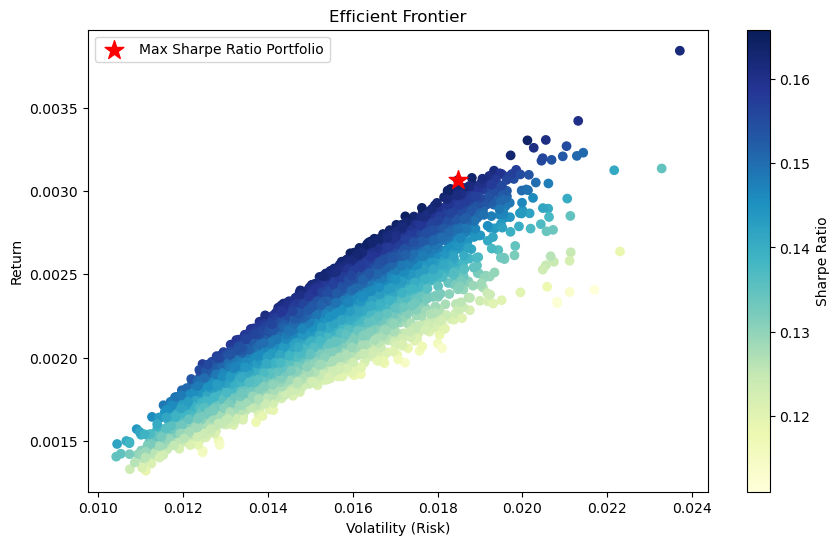

Optimal Portfolio (Max Sharpe Ratio):
Return: 0.0031
Volatility: 0.0185
Sharpe Ratio: 0.1659
Portfolio Weights: Weight    0.224523
Name: 7436, dtype: float64


In [4]:
# check for portfolio of stocks
# List of tickers for your portfolio
stock_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'SPY']

# Download historical data
start_date = '2023-01-01'
end_date = datetime.date.today()
data = download_stock_data(stock_symbols, start_date, end_date)

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate expected returns (mean of daily returns)
expected_returns = returns.mean()

# Calculate the covariance matrix
cov_matrix = returns.cov()

# Define the number of portfolios to simulate
num_portfolios = 10000

# Initialize arrays to store results
results = np.zeros((4, num_portfolios))

for i in range(num_portfolios):
    # Randomly assign weights to the stocks
    weights = np.random.random(len(stock_symbols))
    weights /= np.sum(weights)  # Normalize weights to sum to 1

    # Calculate portfolio return
    portfolio_return = np.sum(weights * expected_returns)

    # Calculate portfolio volatility (risk)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Calculate portfolio Sharpe ratio (assuming risk-free rate is 0)
    sharpe_ratio = portfolio_return / portfolio_volatility

    # Store the results
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio
    results[3, i] = weights[0]  # Store weight of the first stock (just for reference)

# Convert results to a DataFrame
portfolio_results = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio', 'Weight'])

# Find the portfolio with the highest Sharpe ratio
max_sharpe_idx = portfolio_results['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = portfolio_results.iloc[max_sharpe_idx]

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_results.Volatility, portfolio_results.Return, c=portfolio_results['Sharpe Ratio'], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')

# Plot the maximum Sharpe ratio portfolio
plt.scatter(max_sharpe_portfolio[1], max_sharpe_portfolio[0], color='red', marker='*', s=200, label='Max Sharpe Ratio Portfolio')

# Show the plot
plt.legend(loc='upper left')
plt.show()

# Print the optimal portfolio (maximum Sharpe ratio)
print("Optimal Portfolio (Max Sharpe Ratio):")
print(f"Return: {max_sharpe_portfolio[0]:.4f}")
print(f"Volatility: {max_sharpe_portfolio[1]:.4f}")
print(f"Sharpe Ratio: {max_sharpe_portfolio[2]:.4f}")
print(f"Portfolio Weights: {max_sharpe_portfolio[3:]}")


[*********************100%%**********************]  3 of 3 completed


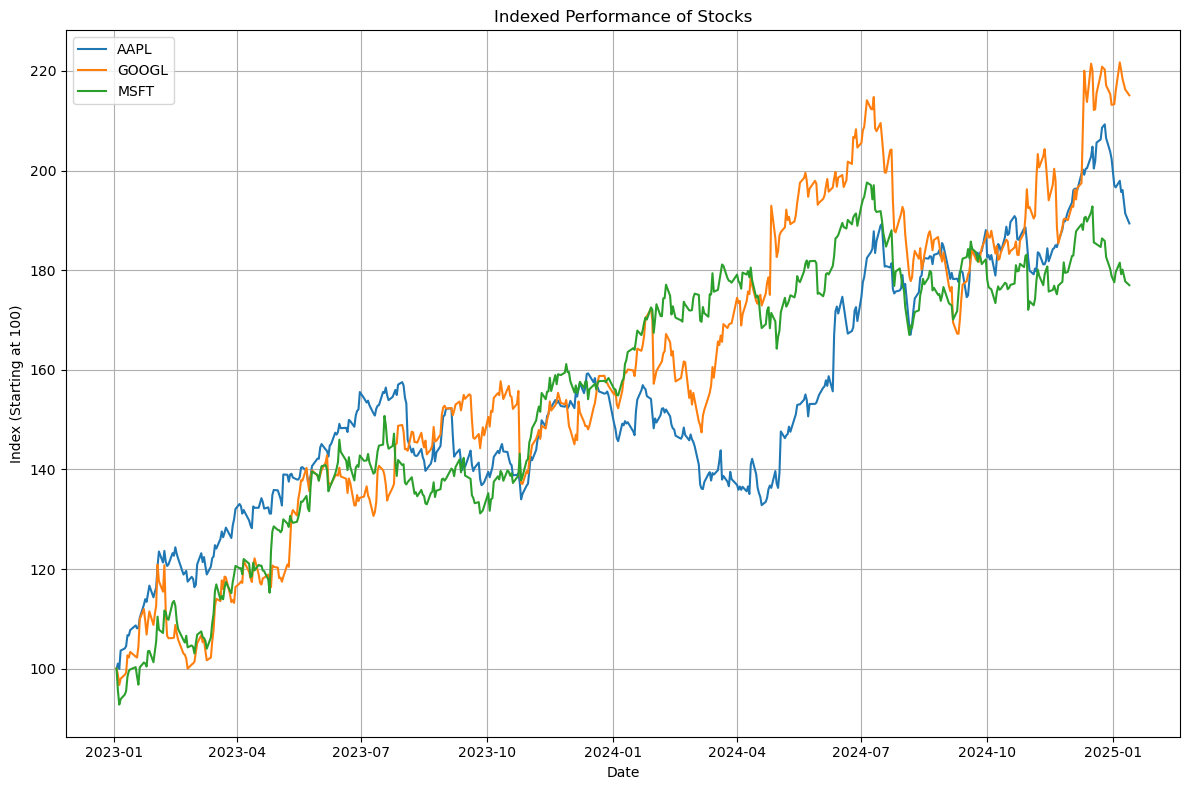

In [5]:
# List of stock symbols and date range
tickers = ['AAPL', 'MSFT', 'GOOGL']  # Example: Apple, Microsoft, Alphabet, ^GSPC
start_date = '2023-01-01'
end_date = datetime.date.today()
# Compare stocks by index
compare_stocks_by_index(tickers, start_date, end_date)

[*********************100%%**********************]  2 of 2 completed


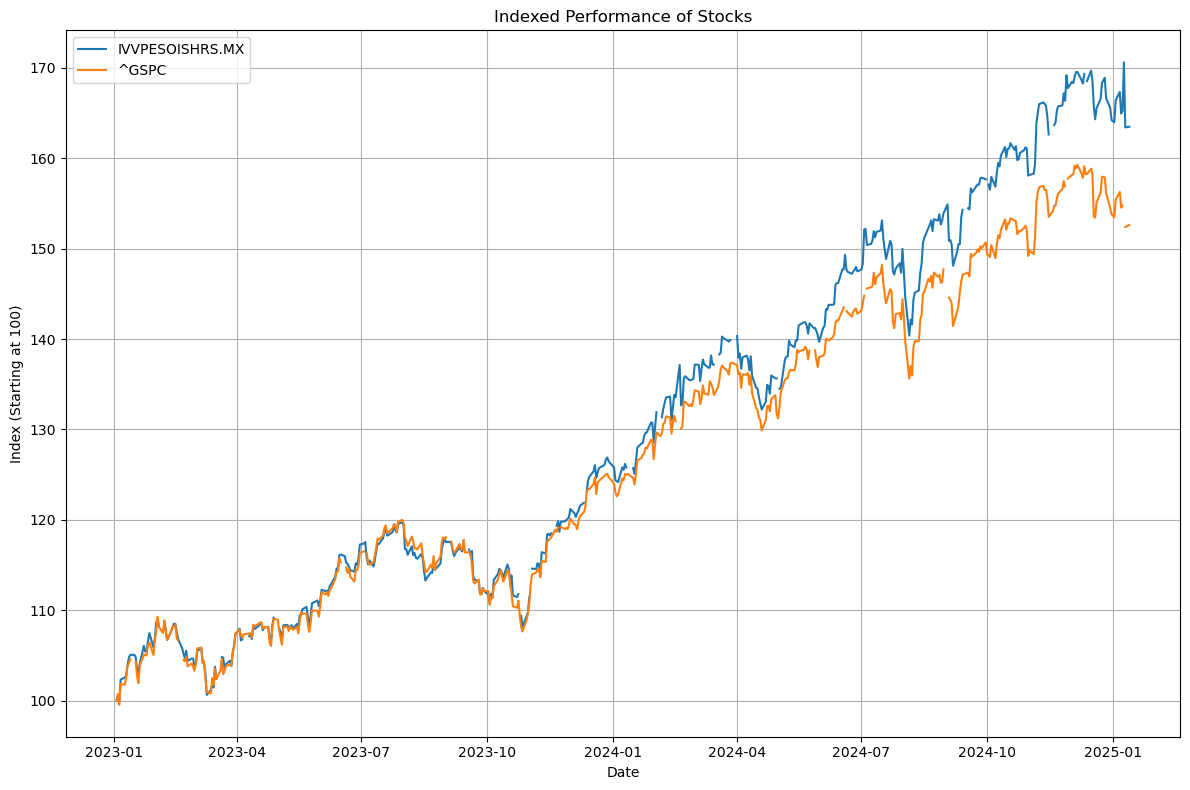

In [6]:
# List of stock symbols and date range
tickers = ['IVVPESOISHRS.MX', '^GSPC']  # Example: Apple, Microsoft, Alphabet, ^GSPC
start_date = '2023-01-01'
end_date = datetime.date.today()
# Compare stocks by index
compare_stocks_by_index(tickers, start_date, end_date)

[*********************100%%**********************]  3 of 3 completed


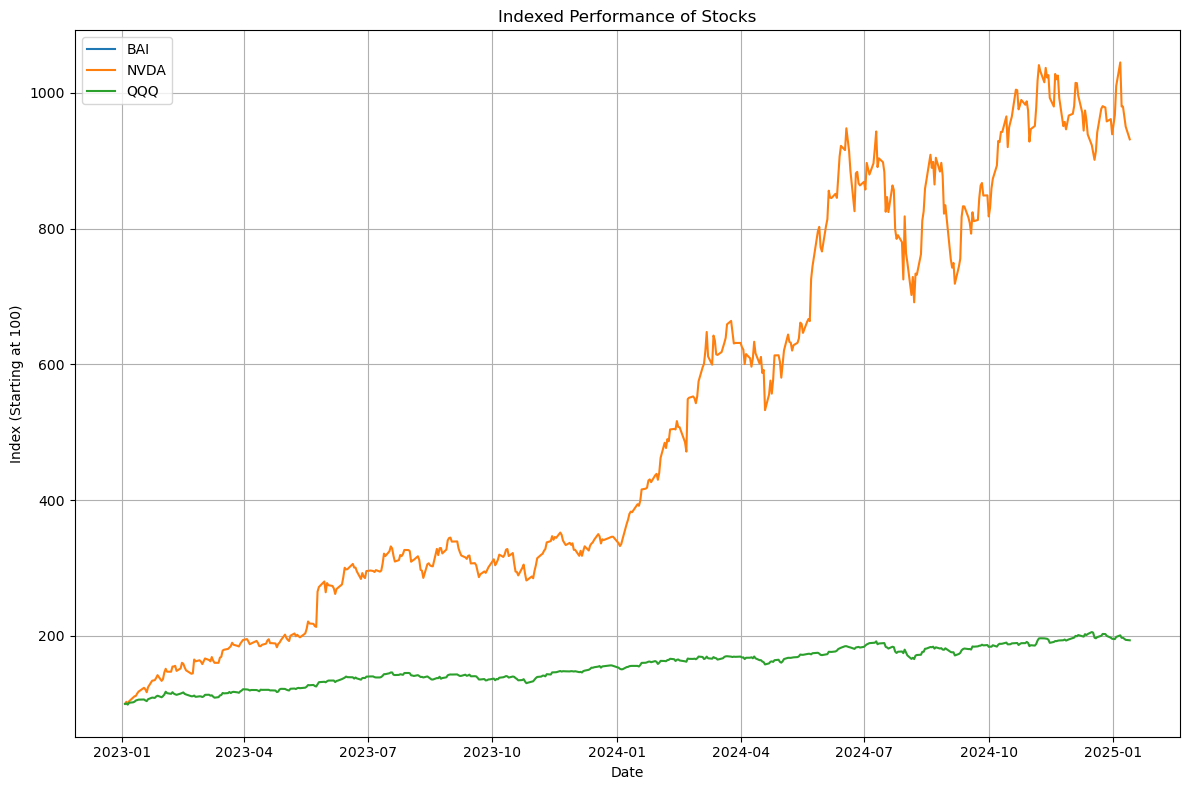

In [7]:
# List of stock symbols and date range
tickers = ['NVDA', 'QQQ', 'BAI']  # Example: Apple, Microsoft, Alphabet, ^GSPC
start_date = '2023-01-01'
end_date = datetime.date.today()
# Compare stocks by index
compare_stocks_by_index(tickers, start_date, end_date)

[*********************100%%**********************]  5 of 5 completed


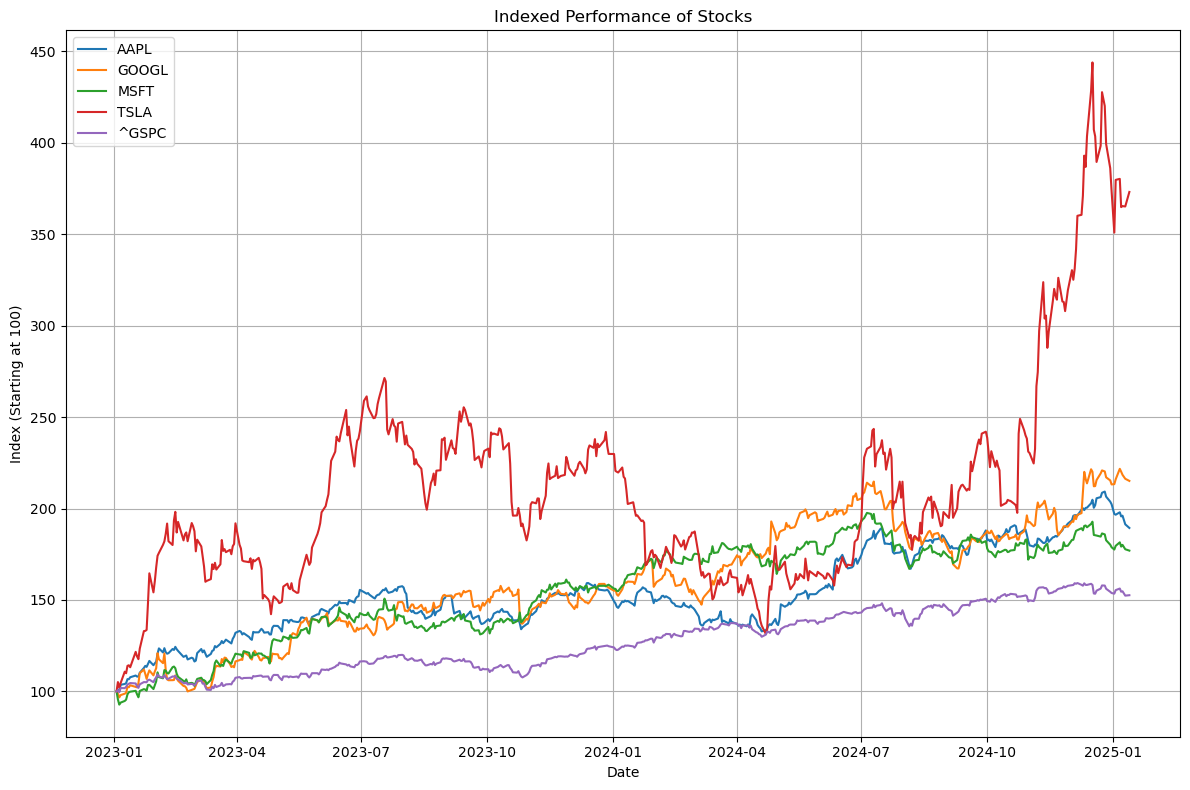

In [8]:
# List of stock tickers
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "^GSPC"]  # Example: Apple, Microsoft, Alphabet, Tesla
start_date = "2023-01-01"
end_date = datetime.date.today()

# Compare stocks by index
compare_stocks_by_index(tickers, start_date, end_date)

  Ticker   P/E Ratio
0   AAPL   38.406918
1   MSFT   34.199173
2  GOOGL   25.115383
3   TSLA  108.476830
4   NVDA   51.843872
5   NFLX   46.734913
[array([0, 1, 2, 3, 4, 5]), array([0, 1]), array([[ 25.115383,  34.199173,  38.406918,  46.734913,  51.843872,
        108.47683 ]])]


TypeError: Dimensions of C (1, 6) are incompatible with X (6) and/or Y (2); see help(pcolormesh)

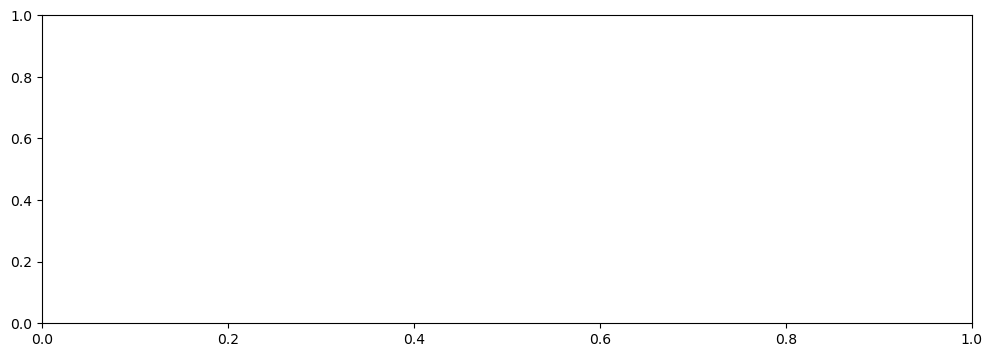

In [9]:
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "NFLX"]  # Example: Apple, Microsoft, Alphabet, Tesla
compare_pe_ratios(tickers,2)

In [10]:
# List of stock tickers
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA"]  # Example: Apple, Microsoft, Alphabet, Tesla

# Compare stocks growth and peg
compare_growth_and_peg(tickers)

NO data:   Ticker   P/E Ratio  Growth Rate PEG Ratio
0   AAPL   38.415154       -0.358      None
1   MSFT   34.196693        0.107      None
2  GOOGL   25.116049        0.336      None
3   TSLA  108.505066        0.169      None


In [11]:
# List of stock tickers
tickers = ["BTC", "BTCO", "BITB", "XLF", "KBWB"]  # Example: Apple, Microsoft, Alphabet, Tesla
start_date = "2023-01-01"
end_date = datetime.date.today()

# Compare stocks by peg
compare_growth_and_peg(tickers)

NO data:   Ticker  P/E Ratio Growth Rate PEG Ratio
0    BTC        NaN        None      None
1   BTCO        NaN        None      None
2   BITB        NaN        None      None
3    XLF  17.063768        None      None
4   KBWB  15.612874        None      None


In [14]:
#import yfinance as yf
#import pandas as pd
#import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def fetch_stock_data(tickers):
    """
    Fetch stock prices, industry, and last 10 days' closing prices.
    
    Parameters:
    - tickers (list): List of stock tickers.
    
    Returns:
    - pd.DataFrame: DataFrame containing stock information.
    """
    stock_info = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            industry = info.get('industry', 'N/A')
            price = info.get('currentPrice', None)
            
            # Fetch historical data for the last 20 days
            hist = stock.history(period="1mo")
            close_prices = hist['Close'].values
            
            # Calculate percentage change
            trend_percentage = ((close_prices[-1] - close_prices[0]) / close_prices[0]) * 100
            
            stock_info.append({
                "Ticker": ticker,
                "Industry": industry,
                "Price": price,
                "Trend (%)": trend_percentage,
                "Close Prices": close_prices
            })
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            stock_info.append({
                "Ticker": ticker,
                "Industry": "N/A",
                "Price": None,
                "Trend (%)": None,
                "Close Prices": []
            })
    return pd.DataFrame(stock_info)

def plot_board(data):
    """
    Plot a stock board with ticker, industry, price, trend, and last 10 days' graph.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing stock information.
    """
    fig = plt.figure(figsize=(12, len(data) * 2))
    gs = GridSpec(len(data), 3, width_ratios=[1, 3, 3], height_ratios=[1]*len(data))
    
    for i, row in data.iterrows():
        # Add text-based details
        ax_text = fig.add_subplot(gs[i, 0])
        ax_text.axis("off")
        text = (
            f"Ticker: {row['Ticker']}\n"
            f"Industry: {row['Industry']}\n"
            f"Price: {row['Price']:.2f} USD\n"
            f"Trend: {row['Trend (%)']:.2f}%"
        )
        ax_text.text(0, 0.5, text, fontsize=10, va='center', ha='left')
        
        # Add small widget graph
        ax_graph = fig.add_subplot(gs[i, 1:])
        ax_graph.plot(row["Close Prices"], color='green' if row["Trend (%)"] >= 0 else 'red')
        ax_graph.fill_between(range(len(row["Close Prices"])), row["Close Prices"],
                              color='green' if row["Trend (%)"] >= 0 else 'red', alpha=0.3)
        ax_graph.set_xticks([])
        ax_graph.set_yticks([])
        ax_graph.set_title(f"{row['Ticker']} Last 20 Days", fontsize=10)
    
    plt.tight_layout()
    plt.show()

def create_stock_board(tickers):
    """
    Create a stock board from a list of tickers.
    
    Parameters:
    - tickers (list): List of stock tickers.
    """
    # Fetch stock data
    stock_data = fetch_stock_data(tickers)
    
    # Plot the board
    plot_board(stock_data)

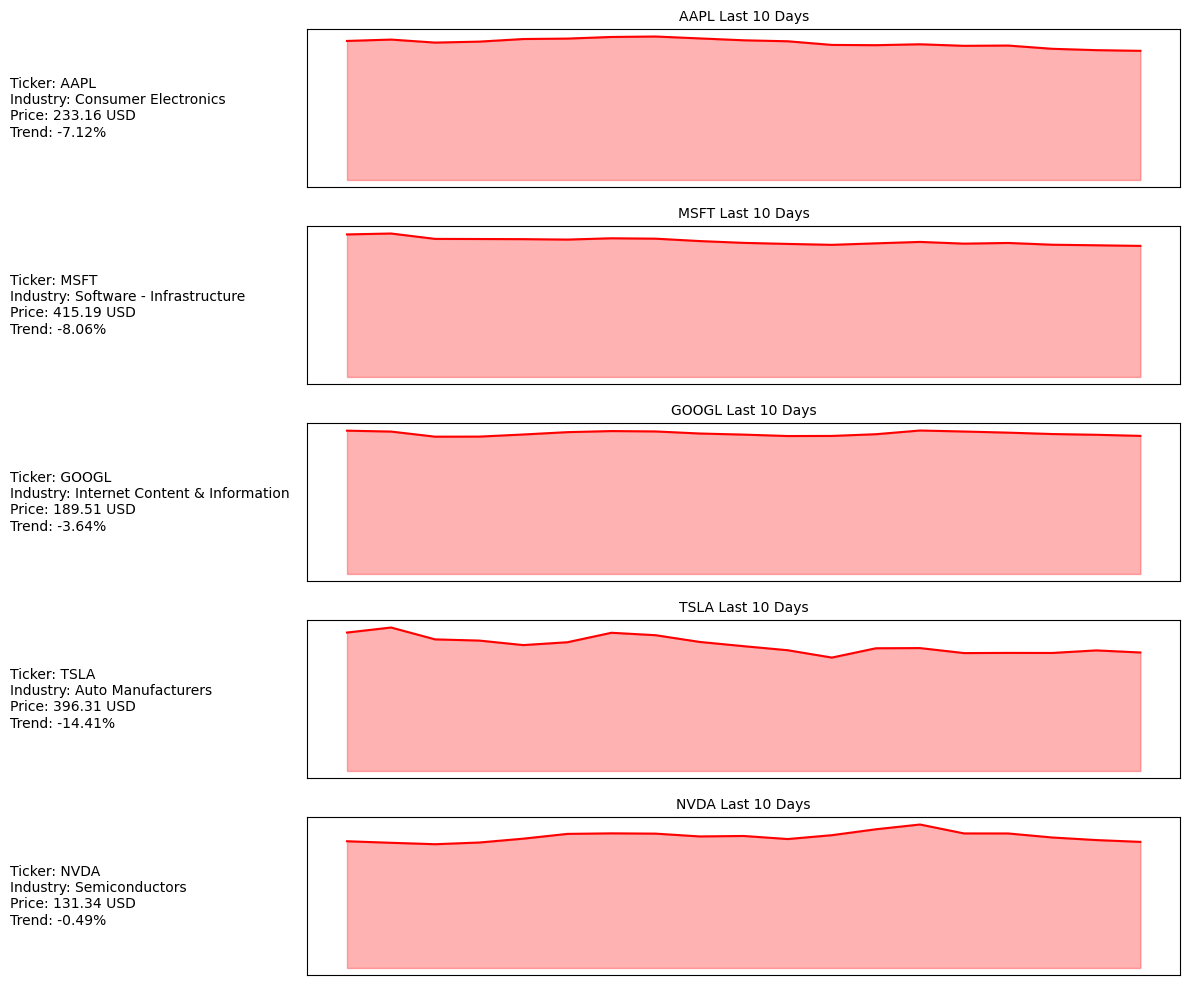

In [15]:
# Example usage
stock_list = ["AAPL", "MSFT", "GOOGL", "TSLA", "NVDA"]  # Example stock tickers
create_stock_board(stock_list)
